In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import PIL.Image

PIL.Image.MAX_IMAGE_PIXELS = None
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [35]:
from wandb.fastai import WandbCallback
import wandb 

wandb.init(project='danbooru2018', name='256px')

W&B Run: https://app.wandb.ai/rf5/danbooru2018/runs/3z3ncd0s

In [3]:
from fastai import *
from fastai.vision import *
import json
from pathlib import Path

path = './'

arch = models.resnet50
src = ImageList.from_csv(path, 'tag_labels_6000.csv').split_by_rand_pct(0.1, seed=15)
with open('class_names.pkl','rb') as f: classes = pickle.load(f).index.tolist()
src = src.label_from_df(label_delim=' ', classes=classes)

In [4]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.15, max_warp=0.1)

stats_override = None
if Path('danbooru_stats.json').is_file():
    with open('danbooru_stats.json', 'r') as f:
        stats_override = json.loads(f.read())
        stats_override = (stats_override['mean'], stats_override['std'])

def get_data(bs, size):
    if stats_override == None:
        data = (src.transform(tfms, size=size)
               .databunch(bs=bs).normalize())
    else:
        print("Using stats ", stats_override)
        data = (src.transform(tfms, size=size)
               .databunch(bs=bs).normalize(stats_override))
    return data

In [8]:
# data = get_data(512, 64)
data = get_data(512, 128)

Using stats  ([0.713739812374115, 0.6627991795539856, 0.6518916487693787], [0.2969885468482971, 0.3017076551914215, 0.2979130446910858])


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2575: DecompressionBombWarning: Image size (102667552 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


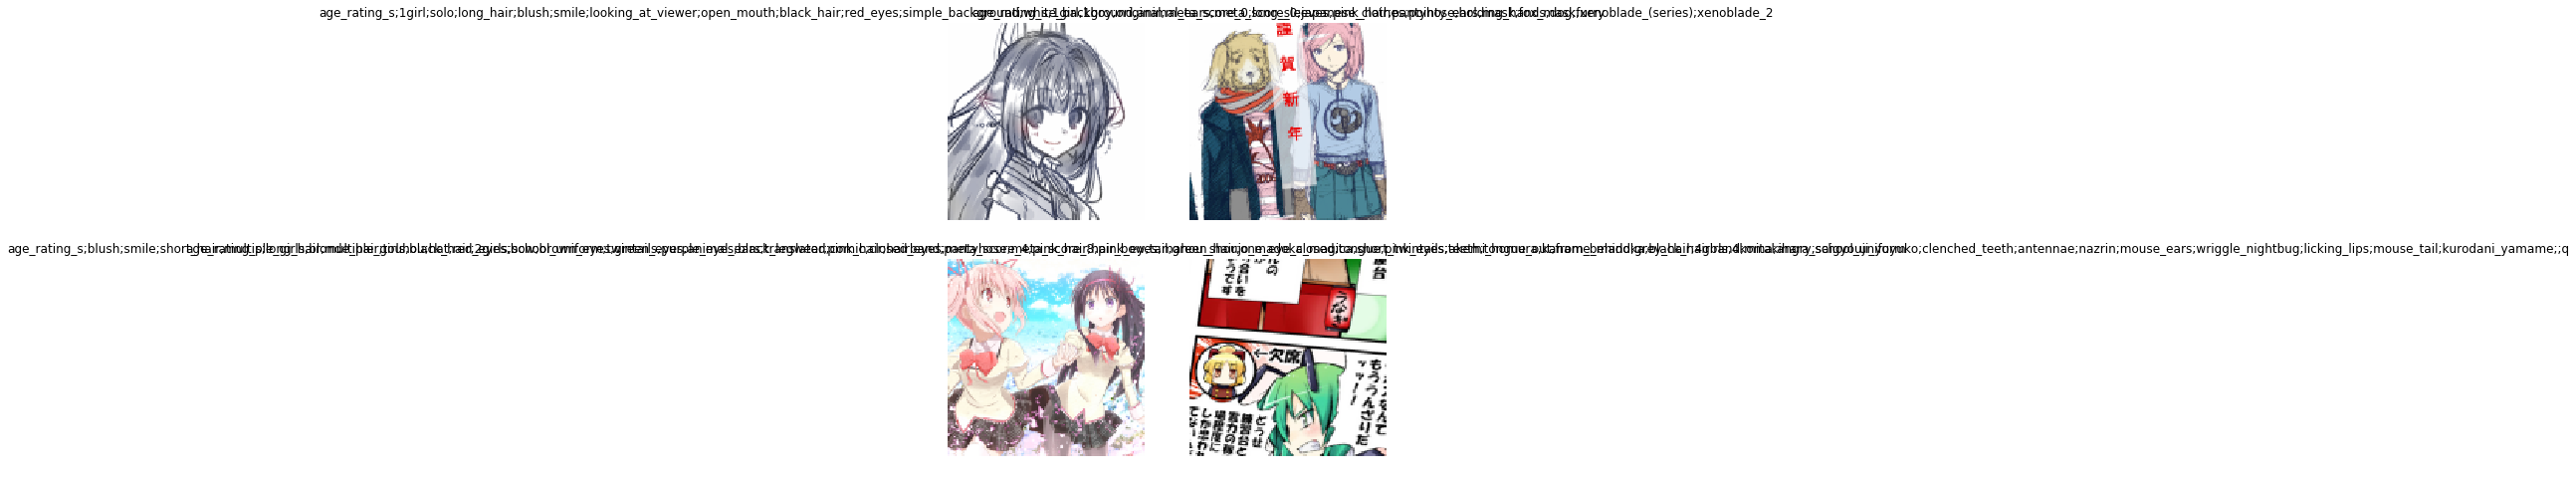

In [10]:
data.show_batch(rows=2)

In [5]:
data = get_data(64, 360)

Using stats  ([0.713739812374115, 0.6627991795539856, 0.6518916487693787], [0.2969885468482971, 0.3017076551914215, 0.2979130446910858])


In [10]:
from fastai.callbacks.mem import PeakMemMetric
from fastai.callbacks.csv_logger import CSVLogger
from telegram_notifier import TelegramNotifier

acc_04 = partial(accuracy_thresh, thresh=0.4)
f_score = partial(fbeta, thresh=0.4)
acc_02 = partial(accuracy_thresh, thresh=0.2)

learn = cnn_learner(data, arch, pretrained=True, 
                    metrics=[f_score, acc_04, acc_02], 
                    callback_fns=[PeakMemMetric, partial(CSVLogger, append=True), partial(
                        TelegramNotifier, 
                        chat_id=646779078, 
                        token="749113443:AAHeWqXQpI2eDWf84wkCeyQ6x6bjakmFONI")]).load('r50f-1c-256')#.load('r50f-1a')
gc.collect();

In [8]:
learn = learn.to_fp32()

In [38]:
learn = learn.to_fp16(loss_scale=2048) # set my loss scale to 512*2

In [11]:
learn.lr_find()
# learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


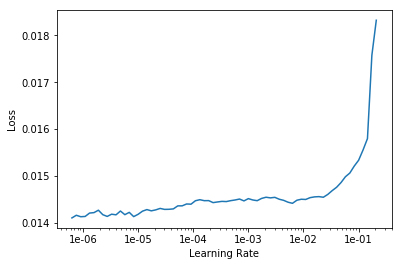

In [12]:
learn.recorder.plot()

In [13]:
import os, functools, traceback, gc, sys

def is_in_ipython():
    "Is the code running in the ipython environment (jupyter including)"

    program_name = os.path.basename(os.getenv('_', ''))

    if ('jupyter-notebook' in program_name or # jupyter-notebook
        'ipython'          in program_name or # ipython
        'JPY_PARENT_PID'   in os.environ):    # ipython-notebook
        return True
    else:
        return False

IS_IN_IPYTHON = is_in_ipython()

def is_in_colab():
    "Is the code running in Google Colaboratory?"
    if not IS_IN_IPYTHON: return False
    try:
        from google import colab
        return True
    except: return False

IS_IN_COLAB = is_in_colab()

def get_ref_free_exc_info():
    "Free traceback from references to locals() in each frame to avoid circular reference leading to gc.collect() unable to reclaim memory"
    type, val, tb = sys.exc_info()
    traceback.clear_frames(tb)
    return (type, val, tb)

def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        tb_clear_frames = os.environ.get('FASTAI_TB_CLEAR_FRAMES', None)
        if not IS_IN_IPYTHON or tb_clear_frames=="0":
            return func(*args, **kwargs)

        try:
            return func(*args, **kwargs)
        except Exception as e:
            if ("CUDA out of memory" in str(e) or
                "device-side assert triggered" in str(e) or
                tb_clear_frames == "1"):
                type, val, tb = get_ref_free_exc_info() # must!
                gc.collect()
                if "device-side assert triggered" in str(e):
                    warn("""When 'device-side assert triggered' error happens, it's not possible to recover and you must restart the kernel to continue. Use os.environ['CUDA_LAUNCH_BLOCKING']="1" before restarting to debug""")
                raise type(val).with_traceback(tb) from None
            else: raise # re-raises the exact last exception
    return wrapper

class gpu_mem_restore_ctx():
    "context manager to reclaim RAM if an exception happened under ipython"
    def __enter__(self): return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        if not exc_val: return True
        traceback.clear_frames(exc_tb)
        gc.collect()
        raise exc_type(exc_val).with_traceback(exc_tb) from None

In [14]:
# @gpu_mem_restore
def do_fit(lll, save_name, lrs, epochs=1):
    lll.fit_one_cycle(epochs, lrs)
    lll.save(save_name)
    lll.show_results(rows=3, imgsize=7)

In [ ]:
learn.unfreeze()
lr = slice(1e-5, 3e-3)
do_fit(learn, 'r50f-1a', lr)

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,accuracy_thresh,time


In [17]:
norm_consts = {'mean': learn.data.stats[0].tolist(), 'std': learn.data.stats[1].tolist()}

In [9]:
norm_consts

{'mean': [0.713739812374115, 0.6627991795539856, 0.6518916487693787],
 'std': [0.2969885468482971, 0.3017076551914215, 0.2979130446910858]}

In [ ]:
learn.unfreeze()
lr = slice(3e-5, 4e-3)
do_fit(learn, 'r50f-1b-128', lr)

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,accuracy_thresh,cpu used,peak,gpu used,peak,time


In [ ]:
learn.unfreeze()
lr = slice(2e-5, 3e-4)
do_fit(learn, 'r50f-1c-256', lr)

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,accuracy_thresh,cpu used,peak,gpu used,peak,time


In [31]:
learn.export()

In [11]:
gc.collect()

0

In [16]:
learn.save('r50f-1c-256')

In [7]:
learn.export()

In [ ]:
lr = slice(4e-6, 3e-5)
do_fit(learn, 'r50f-1d-360', lr)

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,accuracy_thresh,cpu used,peak,gpu used,peak,time


In [ ]:
print("Hello")